## Introduction

Exploring the refinement of the T5 model for text summarization, this initiative targets the extraction of essential information with coherence. T5's adaptability is leveraged to address challenges in summarizing diverse document structures and writing styles. The problem lies in attaining nuanced, domain-specific summaries, often hindered by generic approaches. Through fine-tuning T5, this endeavor aims to enhance summarization accuracy and relevance, delivering tailored solutions across varied content domains.

## Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


pl.seed_everything(100)

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(torch.__version__)

2.0.0


## Fine-Tuning HuggingFace Models

Fine-tuning the T5-base Hugging Face model involves adapting the pre-trained T5 transformer for a specific task. This process includes preparing a task-specific dataset, modifying the model architecture if needed, and training it on the new dataset. The fine-tuned model is then evaluated and can be deployed for the target task.


Fine-Tuning a model through fine-tuning yields several advantages:

**Enhanced Performance:** The process optimizes the model's performance on a particular task by adjusting hyperparameters and architecture to align with the task's characteristics and dataset.

**Transfer Learning Utilization:** Fine-tuning a pre-trained model harnesses transfer learning, leveraging knowledge acquired from one task to enhance performance on a related task. This approach saves time and resources compared to training a model from the ground up.

**Precise Control:** Fine-tuning provides fine-grained control over the model's behavior, enabling specific adjustments to meet specific requirements.

**Tailored Customization:** The process allows customization of the model to cater to the nuances of a particular task or dataset. This proves beneficial when unique requirements are not addressed by readily available models.

In [3]:
df = pd.read_csv("/kaggle/input/news-summary/news_summary.csv", encoding='ISO-8859-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


## Import Dataset

In [4]:
df=df[["text","ctext"]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [5]:
df.columns = ["summary", "text"]
df.dropna(inplace=True)
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
df.shape

(4396, 2)

### Splitting the data into train and test

In [7]:
train_df,test_df = train_test_split(df, test_size=0.1)
print("Training size: "+ str(train_df.shape[0]))
print("Testing size: "+ str(test_df.shape[0]))

Training size: 3956
Testing size: 440


## Dataset Preparation

In [8]:
class NewsSummaryDataset:

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len = 512,
        summary_max_token_len = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        text = data_row["text"]
        
        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        
        summary_encoding = tokenizer(
            data_row["summary"],
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )


        labels = summary_encoding["input_ids"]
        labels[labels == 0] = -100  # As per T5 Documentation
        
        return dict(
            text=text,
            summary=data_row["summary"],
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten(),
        )

## DataLoader

In [9]:
class NewsSummaryDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int=8,
        text_max_token_len: int=512,
        summary_max_token_len: int=128
    ):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len


    def setup(self, stage=None):

        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
         self.train_dataset,
         batch_size=self.batch_size,
         shuffle=True, 
         num_workers=2
        )


    def val_dataloader(self):
        return torch.utils.data.DataLoader(
         self.test_dataset,
         batch_size=self.batch_size,
         shuffle=False,
         num_workers=2
        )

### T5 Tokenizer

In [10]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
text_token_counts, summary_token_counts = [], []
for _,row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)
    
    summary_token_count = len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Summary token counts')

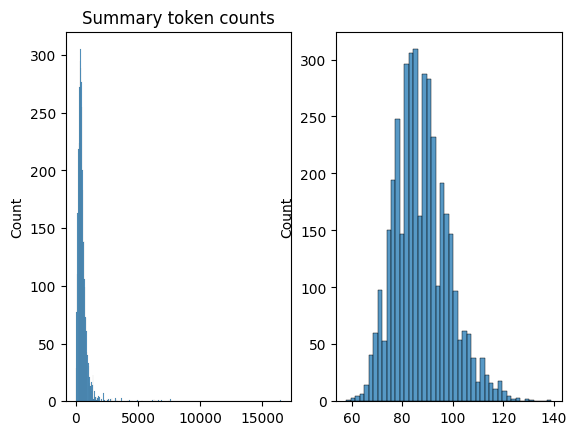

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts, ax=ax2)
ax1.set_title("Summary token counts")

### Initialize Parameters

In [13]:
N_EPOCHS = 3
BATCH_SIZE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## Model Building

In [14]:
class NewsSummaryModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

        output = self.model(
            input_ids, 
            attention_mask=attention_mask, 
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits


    def training_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels= batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )
        
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss


    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)


## Model Training

In [15]:
def run():

    
    dataModule = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)
    dataModule.setup()

    device = DEVICE
    models = NewsSummaryModel()
    models.to(device)

    checkpoint_callback  = ModelCheckpoint(
        dirpath="/kaggle/working",
        filename="best_checkpoint",
        save_top_k=1,
        verbose=True,
        monitor="val_loss",
        mode="min"
    )

    trainer = pl.Trainer(
        callbacks = checkpoint_callback,
        max_epochs= N_EPOCHS,
        accelerator="gpu"
    )

    trainer.fit(models, dataModule)

run()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Model Prediction

In [16]:
trained_model = NewsSummaryModel.load_from_checkpoint("/kaggle/working/best_checkpoint.ckpt")

trained_model.freeze()

In [19]:
def summarize(text, model, tokenizer, device):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )
    
    text_encoding = {key: value.to(device) for key, value in text_encoding.items()}
    model = model.to(device)
    decoder_attention_mask = text_encoding["attention_mask"].to(device)
    
    generated_ids = model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=decoder_attention_mask,
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]
    
    return "".join(preds)


### Output

In [34]:
sample_row = test_df.iloc[5]
text = sample_row["text"]
model_summary =summarize(text, trained_model, tokenizer, DEVICE)

In [37]:
print("Input Text: \n")
print(text)
print("-----------------------------------------------------------------------------------------------")
print("Output Summary: \n")
print(sample_row["summary"])
print("-----------------------------------------------------------------------------------------------")
print("Original Summary: \n")
print(model_summary)

Input Text: 

From K J M Varma Beijing, Mar 8 (PTI) Chinas Parliament has given its approval to President Xi Jinpings elevation as the "core leader", reinforcing his hold over all the organs of power, ahead of his second five-year tenure. The core leader status, that had been earlier been approved by the ruling Communist Party, puts 63-year-old Xi at par with party founder Mao Zedong, his successor and reformist leader Deng Xiaoping and elevates him to a higher status above others in the Communist Party of Chinas (CPC) collective leadership system. Chinas top legislator Zhang Dejiang pledged further conformity to the CPC Central Committee with Xi as the core, state-run Xinhua news agency reported today. National lawmakers should unite more closely "around the CPC Central Committee with Xi Jinping as the core," to develop the system of the peoples congress and realise the dream of national rejuvenation, Zhang, the chairman of the National Peoples Congress (NPC) Standing Committee, said 